In [3]:
from functions import Model, get99, reg_train_test, splitData, dropMissingValues, z_score, outliers_knn, outliers_dbscan, getNoise, getRelFeatures, drop_features, getCombinations, get_unique_list, bold, blue, red, green, np_to_df, df_to_np
import pandas as pd
from sklearn.linear_model import LinearRegression
import warnings
import numpy as np
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


In [4]:
#TODO SPLIT_SIZE = [0.15, 0.25, 0.33]
SPLIT_SIZE = 0.25

#TODO OUTLIER99 = [] 

OUTLIER_ZSCORE = {"STD": [3]}
OUTLIER_KNN = {"K": [3], "X": [200]}
OUTLIER_DBSCAN = {"K": [3], "X": [200, 1000], "EPS": [0.42, 0.5], "MIN_SAMPLES": [5, 10]} #?? gute auswahl
OUTLIER_NOISE = {"CV": [10]}

#TODO FEATURE

#TODO Regressionmodels

#TODO TESTDATA --> path to csv-file


In [5]:
#Get raw Data
df = pd.read_csv("data/csv/house_data_training.csv", sep=';') 
# remove unnamed column
df = df.iloc[:, 1:]
#Transform string to datetime
df["date"] = pd.to_datetime(df["date"])

maeList = []#for model selection

In [6]:
df = dropMissingValues(df) 

In [7]:
# Outlier Detection
outlier_lists_all = []

outlier_list_99 = get99(df) #TODO Mean for price for trainingsdata

print('starting z_score')
for p in OUTLIER_ZSCORE["STD"]:
    print(p)
    outlier_list_z_score = z_score(df, p)
    outlier_lists_all.append(outlier_list_z_score)


print('done \n\n starting knn')
for k in OUTLIER_KNN["K"]:
    for o in OUTLIER_KNN["X"]:
        print(k, o)
        outlier_list_knn = outliers_knn(df, k, o)
        outlier_lists_all.append(outlier_list_knn)

print('done \n\n starting db_scan')
outlier_list_dbscan = outliers_dbscan(df)#too many
outlier_lists_all.append(outlier_list_dbscan)

print('done \n\n starting noise')
for cv in OUTLIER_NOISE["CV"]:
        print(cv)
        outlier_list_noise = getNoise(df, cv)
        outlier_lists_all.append(outlier_list_noise)
print('done')

# outlier_lists_all = [outlier_list_99, outlier_list_z_score, outlier_list_knn, outlier_list_dbscan, outlier_list_noise]

starting z_score
3
done 

 starting knn
3 200
done 

 starting db_scan
done 

 starting noise
10
done


In [8]:
combination_list = []
for i, combo in enumerate(getCombinations(range(len(outlier_lists_all))), 1):
    if not i == 1:
        combination_list.append(combo)
        print('combo #{}: {}'.format(i, combo))

combo #2: (0,)
combo #3: (1,)
combo #4: (2,)
combo #5: (3,)
combo #6: (0, 1)
combo #7: (0, 2)
combo #8: (0, 3)
combo #9: (1, 2)
combo #10: (1, 3)
combo #11: (2, 3)
combo #12: (0, 1, 2)
combo #13: (0, 1, 3)
combo #14: (0, 2, 3)
combo #15: (1, 2, 3)
combo #16: (0, 1, 2, 3)


In [9]:
model_obj_list = []
for i, c in enumerate(combination_list):
    print(f'i: {i}')
    outlier_list = get_unique_list(outlier_lists_all, c)
    try: 
        X_train, X_test, y_train, y_test = splitData(df, SPLIT_SIZE, outlier_list)
        #model = reg_train_test(X_train, X_test, y_train, y_test)
        model = LinearRegression()
        obj = Model(model, (X_train, X_test, y_train, y_test), c)
        model_obj_list.append(obj)
    except:
        print(red("Error in Combination: "), c)
        pass

i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14


In [10]:
#Feature Selection
list_relevant_features = getRelFeatures(df)
#df_dropped_features = drop_features(df, list_relevant_features)

In [11]:
#Summary
df_summary = pd.DataFrame(columns=['combo', 'mae', 'score'])
for o in model_obj_list:
    #print(f'{o.get_type()}, {o.get_comb()}')
    o.train()
    mae, score = o.summary()
    comb = o.get_comb()
    row = {'combo': comb, 'mae': mae, 'score': score}
    df_summary = df_summary.append(row, ignore_index=True)

df_summary.sort_values("mae")



,combo,mae,score
0,"(0,)",6295339.08,0.049526
1,"(1,)",6295339.08,0.049526
2,"(2,)",6295339.08,0.049526
3,"(3,)",6295339.08,0.049526
4,"(0, 1)",6295339.08,0.049526
5,"(0, 2)",6295339.08,0.049526
6,"(0, 3)",6295339.08,0.049526
7,"(1, 2)",6295339.08,0.049526
8,"(1, 3)",6295339.08,0.049526
9,"(2, 3)",6295339.08,0.049526


In [12]:
#row
print(f'{bold("Lowest mae:")} {df_summary[df_summary.mae==df_summary.mae.min()]}')
print(f'\n{bold("Highest score:")} {df_summary[df_summary.score==df_summary.score.max()]}')

#df_summary["mae"].min()

Lowest mae:            combo         mae     score
0           (0,)  6295339.08  0.049526
1           (1,)  6295339.08  0.049526
2           (2,)  6295339.08  0.049526
3           (3,)  6295339.08  0.049526
4         (0, 1)  6295339.08  0.049526
5         (0, 2)  6295339.08  0.049526
6         (0, 3)  6295339.08  0.049526
7         (1, 2)  6295339.08  0.049526
8         (1, 3)  6295339.08  0.049526
9         (2, 3)  6295339.08  0.049526
10     (0, 1, 2)  6295339.08  0.049526
11     (0, 1, 3)  6295339.08  0.049526
12     (0, 2, 3)  6295339.08  0.049526
13     (1, 2, 3)  6295339.08  0.049526
14  (0, 1, 2, 3)  6295339.08  0.049526

Highest score:            combo         mae     score
0           (0,)  6295339.08  0.049526
1           (1,)  6295339.08  0.049526
2           (2,)  6295339.08  0.049526
3           (3,)  6295339.08  0.049526
4         (0, 1)  6295339.08  0.049526
5         (0, 2)  6295339.08  0.049526
6         (0, 3)  6295339.08  0.049526
7         (1, 2)  6295339.08  0.0495

In [13]:
# df_summary[df_summary.mae==df_summary.mae.min()]

# model_obj_list[6]

# Normalization

In [19]:
# Stelle 6 der Model List hat die Kombination mit dem besten MEA
dfNorm = model_obj_list[5]

# Model in jeweiloigen Variablen schreiben
X_train, X_test, y_train, y_test = dfNorm.get_data()

# for i in y_test:
#     y_testN

# X Daten zusammenfassen
npNorm = np.concatenate((X_train, X_test))

npNormY = np.concatenate((y_train, y_test))

print(len(npNorm))

# Column Liste des Orginal DF erstellen
column_list = df.columns.to_list()
column_list.remove("price")

dfNorm = np_to_df(npNorm, column_list)



14997


In [ ]:
# Nur relevante Features auswählen
rel_column_list = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'dis_super', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']

dfNorm = dfNorm[rel_column_list]

rel_np = df_to_np(dfNorm)

## MinMaxScaler

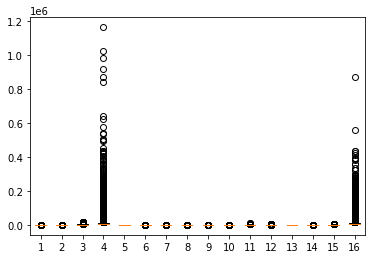

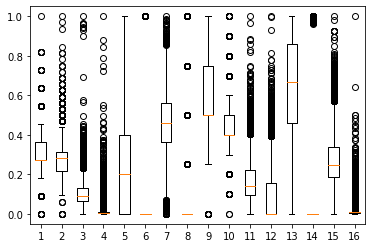

In [ ]:
minmax_scaler = MinMaxScaler()

plt.boxplot(rel_np)
plt.show()

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(rel_np)

scaled_rel_np=minmax_scaler.transform(rel_np)

plt.boxplot(scaled_rel_np)
plt.show()

## RobustScaler

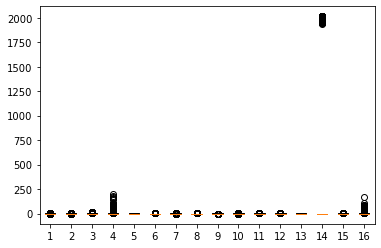

In [ ]:

rob_scaler = RobustScaler()
rob_scaler.fit(rel_np)

scaled_rel_np=rob_scaler.transform(rel_np)

plt.boxplot(scaled_rel_np)
plt.show()

In [ ]:
dfNorm 
dfNorm

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,dis_super,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,3.0,1.50,1110.0,1150.0,2.0,0.0,863.96,0.0,3.0,8.0,940.0,170.0,2007.0,0.0,1380.0,1751.0
1,2.0,1.00,1070.0,6678.0,1.0,0.0,1108.04,0.0,4.0,7.0,1070.0,0.0,1951.0,0.0,1680.0,7788.0
2,3.0,1.50,1660.0,5665.0,1.0,0.0,1154.10,0.0,5.0,7.0,920.0,740.0,1918.0,0.0,1530.0,5665.0
3,4.0,2.25,2350.0,8140.0,1.0,0.0,863.06,0.0,4.0,8.0,1430.0,920.0,1977.0,0.0,2640.0,8700.0
4,4.0,1.50,1720.0,6417.0,1.0,0.0,838.77,0.0,3.0,7.0,1720.0,0.0,1953.0,0.0,1430.0,6240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14680,3.0,1.75,1340.0,13115.0,1.0,0.0,1153.49,0.0,3.0,7.0,1340.0,0.0,1978.0,0.0,1370.0,10800.0
14681,3.0,1.75,1780.0,5175.0,1.0,0.0,1064.61,0.0,4.0,7.0,990.0,790.0,1927.0,0.0,1780.0,5175.0
14682,4.0,1.50,1770.0,5750.0,2.0,0.0,803.12,0.0,3.0,7.0,1770.0,0.0,1947.0,0.0,970.0,5750.0
14683,4.0,2.50,3110.0,5868.0,2.0,0.0,1211.46,0.0,3.0,8.0,3110.0,0.0,2001.0,0.0,2950.0,5924.0


In [ ]:
SPLIT_SIZE = 0.25
dfNorm1 = np_to_df(scaled_rel_np, rel_column_list)



dfNorm1["price"] = npNormY.tolist()


X_train, X_test, y_train, y_test = splitData(dfNorm1, SPLIT_SIZE)
model = LinearRegression()
obj = Model(model, (X_train, X_test, y_train, y_test), "mean")
model_obj_list.append(obj)

NameError: name 'npNormY' is not defined